In [ ]:
!pip install wandb

In [ ]:
!pip install torchmetrics

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import wandb

In [ ]:
wandb.init(project="Pneumonia Classification", entity="kreeeeesha")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: krishachemburkar (kreeeeesha). Use `wandb login --relogin` to force relogin


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
base_path = os.path.join(path, "chest_xray")
train_dir = os.path.join(base_path, "train")
val_dir = os.path.join(base_path, "val")
test_dir = os.path.join(base_path, "test")

In [ ]:
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
])

In [ ]:
train_dataset = datasets.ImageFolder(root=train_dir, transform = transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform = transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform = transform)

In [ ]:
print("Class labels:", train_dataset.class_to_idx)

Class labels: {'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
from collections import Counter

# Count occurrences of each class in the training dataset
train_class_counts = Counter([label for _, label in train_dataset])
test_class_counts = Counter([label for _, label in test_dataset])
val_class_counts = Counter([label for _, label in val_dataset])

# Print class distributions
print("Training dataset class distribution:", dict(train_class_counts))
print("Test dataset class distribution:", dict(test_class_counts))
print("Validation dataset class distribution:", dict(val_class_counts))


Training dataset class distribution: {0: 1341, 1: 3875}
Test dataset class distribution: {0: 234, 1: 390}
Validation dataset class distribution: {0: 8, 1: 8}


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [ ]:
images, labels = next(iter(train_loader))


In [ ]:
images.shape, labels

(torch.Size([32, 3, 320, 320]),
 tensor([1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
         1, 1, 0, 1, 1, 1, 1, 1]))

In [ ]:
images[0].shape

torch.Size([3, 320, 320])

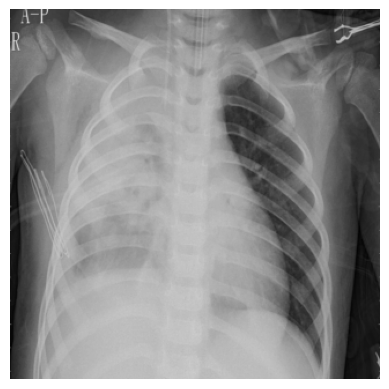

In [ ]:
img = images[0].numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class Classification(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(nn.Conv2d(3,64,(3,3),padding=1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,stride = 2),

                                       nn.Conv2d(64,128,(3,3),stride=1,padding=1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,stride = 2),

                                       nn.Conv2d(128,256,(3,3),stride=1,padding=1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,stride = 2),
                                       nn.Conv2d(256,512,(3,3),stride=1,padding=1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,stride = 2),
                                       nn.Conv2d(512,512,(3,3),stride=1,padding=1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,stride = 2),
                                       nn.Flatten())
        self.classifier = nn.Sequential(nn.Linear(512*10*10,8192),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.BatchNorm1d(8192),
                                        nn.Linear(8192,4096),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.BatchNorm1d(4096),
                                        nn.Linear(4096,2048),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(2048),
                                        nn.Linear(2048,1024),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(1024),
                                        nn.Linear(1024,256),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(256),
                                        nn.Linear(256,64),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(64),
                                        nn.Linear(64,32),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(32),
                                        nn.Linear(32,1),
                                        nn.Sigmoid())
    def forward(self,x):
        x1 = self.feature_extractor(x)
        x = self.classifier(x1)
        return x

In [ ]:
model = Classification()

In [ ]:
model = model.to(device)

In [ ]:
criterion = nn.BCELoss().to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
wandb.log({"learning_rate": optimizer.param_groups[0]['lr']
})


In [ ]:
def calculate_accuracy(outputs, labels):
    predicted = torch.round(torch.sigmoid(outputs))
    correct = (predicted == labels.unsqueeze(1)).sum().item()
    total = labels.size(0)
    return correct, total

In [ ]:
from torchmetrics import Accuracy

def accuracy_fn(y_true, y_pred):
    acc = Accuracy(task="binary").to(device)
    acc = acc(y_pred, y_true.unsqueeze(1))
    return acc

In [ ]:
num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0


    for i, (inputs, labels) in enumerate(train_loader):

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_acc = accuracy_fn(labels, outputs)
            wandb.log({"train_acc_batch": train_acc})
            wandb.log({"train_loss_batch": loss.item()})
            print(f'Loss of batch {i+1}: {loss.item()}')

    epoch_loss = running_loss / len(train_loader)

    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            val_loss += loss.item()

            print(accuracy_fn(labels, outputs))
            wandb.log({"val_acc_batch": accuracy_fn(labels, outputs)})

    avg_val_loss = val_loss / len(test_loader)
    print(outputs, labels)

    print(f'EPOCH {epoch+1}: Training Loss: {epoch_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    wandb.log({
        "train_loss_epoch": epoch_loss,
        "val_loss": avg_val_loss,
        "epoch": epoch + 1
    })



Loss of batch 1: 0.7194414138793945
Loss of batch 2: 0.6348183155059814
Loss of batch 3: 0.6824864149093628
Loss of batch 4: 0.67290198802948
Loss of batch 5: 0.6922541856765747
Loss of batch 6: 0.6751231551170349
Loss of batch 7: 0.6323358416557312
Loss of batch 8: 0.6889661550521851
Loss of batch 9: 0.6640486717224121
Loss of batch 10: 0.7022879123687744
Loss of batch 11: 0.6456665992736816
Loss of batch 12: 0.602948009967804
Loss of batch 13: 0.6972876787185669
Loss of batch 14: 0.5696632266044617
Loss of batch 15: 0.6538211107254028
Loss of batch 16: 0.622411847114563
Loss of batch 17: 0.5982685089111328
Loss of batch 18: 0.61167311668396
Loss of batch 19: 0.5528286695480347
Loss of batch 20: 0.5725982189178467
Loss of batch 21: 0.6131463646888733
Loss of batch 22: 0.6544473171234131
Loss of batch 23: 0.6103869080543518
Loss of batch 24: 0.5621647238731384
Loss of batch 25: 0.5462260842323303
Loss of batch 26: 0.6316685676574707
Loss of batch 27: 0.6154518127441406
Loss of batch 28

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
model = model.to('cpu')

In [ ]:
all_labels = []
all_outputs = []

with torch.no_grad():

  for images, labels in val_loader:
      images, labels = images, labels

      outputs = model(images)
      outputs = torch.round(outputs)

      all_labels.extend(labels.detach().cpu().numpy())
      all_outputs.extend(outputs.squeeze(1).detach().cpu().numpy())

all_labels_val = np.array(all_labels)
all_outputs_val = np.array(all_outputs)

print("All labels:", all_labels)
print("All outputs:", all_outputs)

All labels: [0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1]
All outputs: [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0]


In [ ]:
all_labels = []
all_outputs = []

with torch.no_grad():

  for images, labels in test_loader:
      images, labels = images, labels

      outputs = model(images)
      outputs = torch.round(outputs)

      all_labels.extend(labels.detach().cpu().numpy())
      all_outputs.extend(outputs.squeeze(1).detach().cpu().numpy())

all_labels = np.array(all_labels)
all_outputs = np.array(all_outputs)

print("All labels:", all_labels)
print("All outputs:", all_outputs)

All labels: [0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1
 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1
 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1
 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1
 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0
 0 1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0
 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 0 1 0 0 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 1 0 0 0 1
 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0
 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 1
 1 1 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 1
 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0
 1 0 1 1 1 1 

In [ ]:
cm_val = confusion_matrix(all_labels_val, all_outputs_val)

In [ ]:
cm = confusion_matrix(all_labels, all_outputs)

In [ ]:
cm

array([[174,  60],
       [ 19, 371]])

Confusion Matrix for Test Data


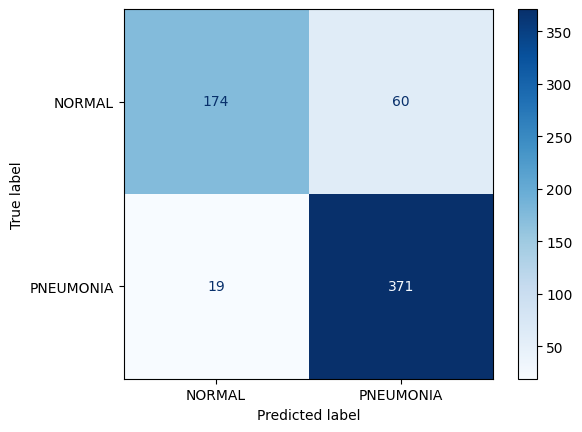

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.classes)

    # Plot confusion matrix
print(f"Confusion Matrix for Test Data")
disp.plot(cmap=plt.cm.Blues)
plt.show()

Confusion Matrix for Val Data


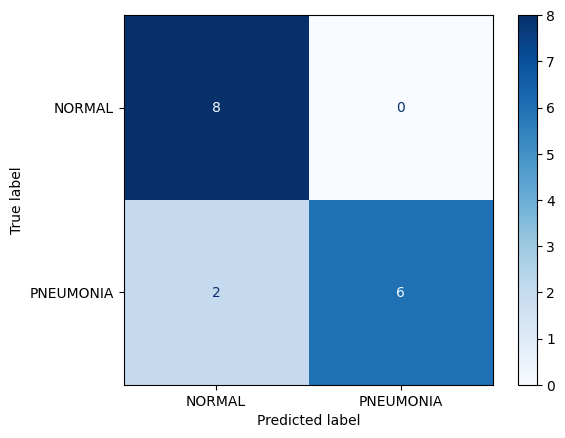

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=val_dataset.classes)

    # Plot confusion matrix
print(f"Confusion Matrix for Val Data")
disp.plot(cmap=plt.cm.Blues)
plt.show()